In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings

warnings.filterwarnings('ignore')


# Data Cleaning and Preprocessing
 
 We execute the following steps based on the observation —

     drop null values.
     change the datatype of the ‘z-axis’ column to float.
     drop the rows where the timestamp is 0.
     sort data in ascending order of the user and timestamp.


In [4]:
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
# har_df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header = None, names = columns)
har_df = pd.read_csv('WISDM_ar_v1.1_raw.txt', header = None, names = columns)

In [5]:
# removing null values
har_df = har_df.dropna()
har_df.shape

(1098203, 6)

In [6]:
# transforming the z-axis to float
# har_df['z-axis'] = har_df['z-axis'].str.replace(';', '')
har_df['z-axis'] = har_df['z-axis'].apply(lambda x:float(x))

In [7]:
# drop the rows where timestamp is 0
df = har_df[har_df['timestamp'] != 0]


In [8]:
# now arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)


# Exploratory Data Analysis
# 

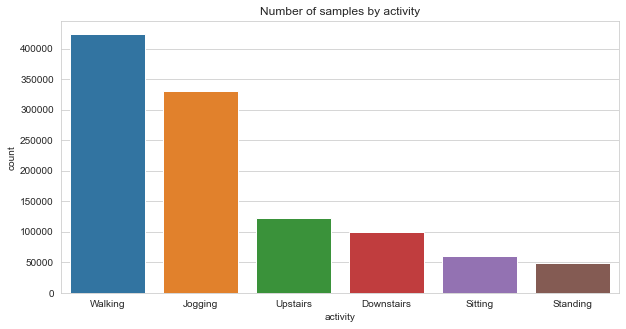

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize = (10, 5))
sns.countplot(x = 'activity', data = df)
plt.title('Number of samples by activity')
plt.show()

As you can see there is a significant class imbalance here with majority of the samples having class-label ‘Walking’ and ‘Jogging’. ‘Standing and ‘Sitting’ activities have least representation in the dataset.

Now let’see how the users are contributing to each activity. This will help us in deciding how to split the data 
for training and testing.

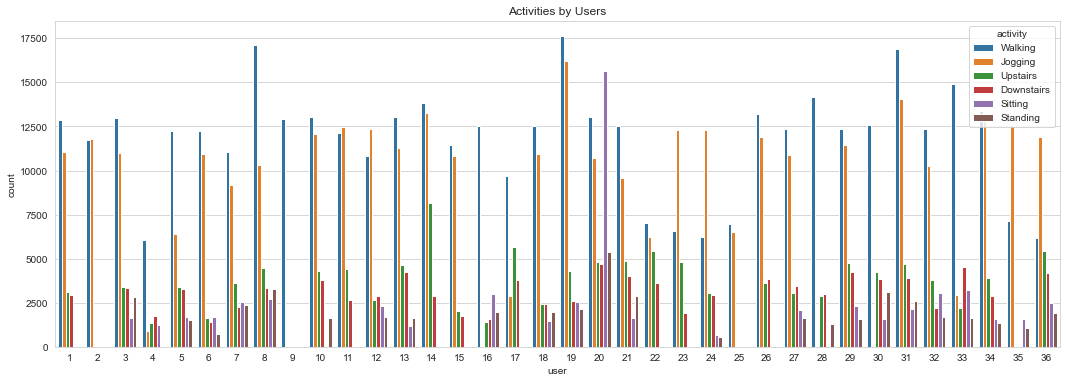

In [10]:
plt.figure(figsize = (18, 6))
sns.countplot(x = 'user', hue = 'activity', data = df)
plt.title('Activities by Users')
plt.show()

 As it can be seen, not all the users are performing all the activities. The time for which they perform each activity also varies. Regardless, this won’t be affecting 
 our subsequent analysis as we have sufficiently large number of data samples and  we are assuming all the users are alike.

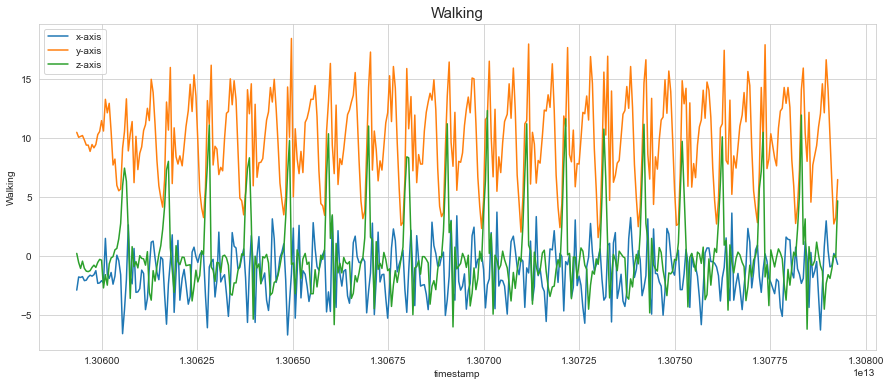

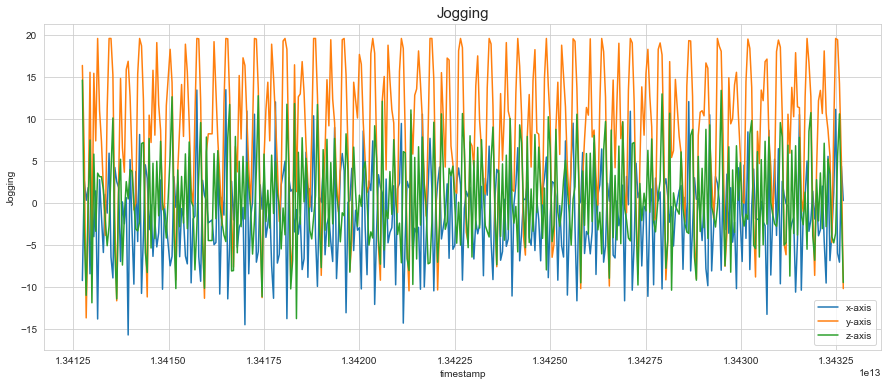

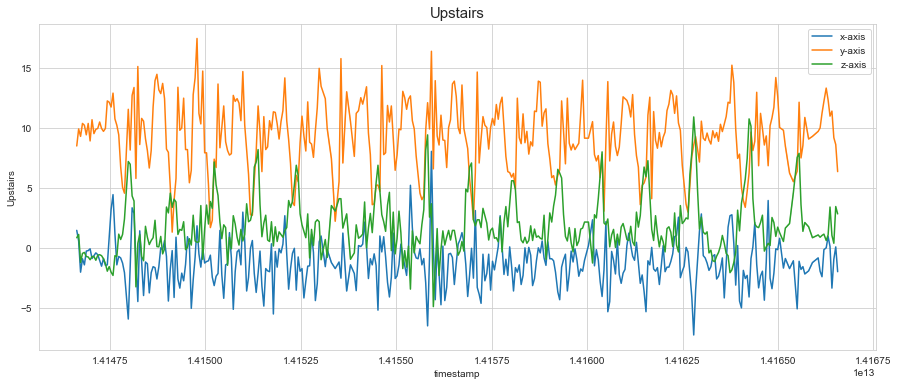

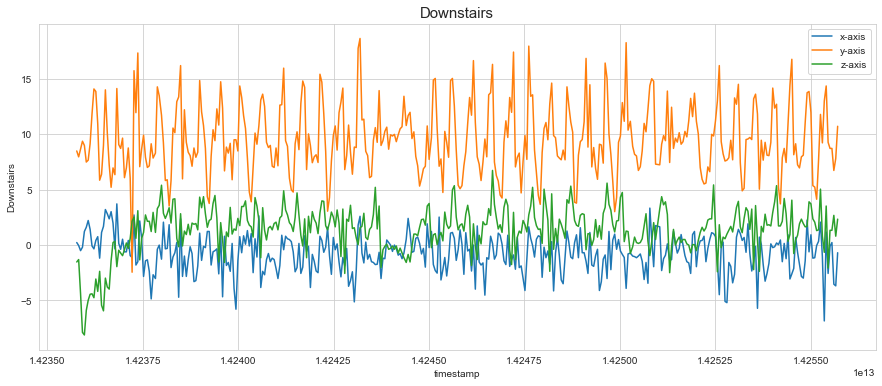

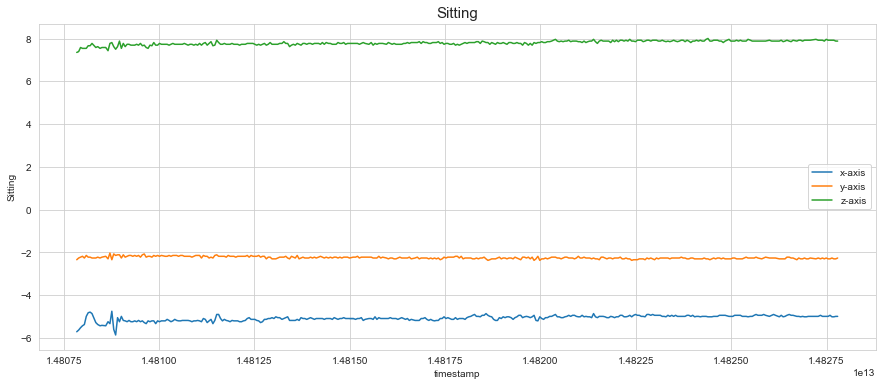

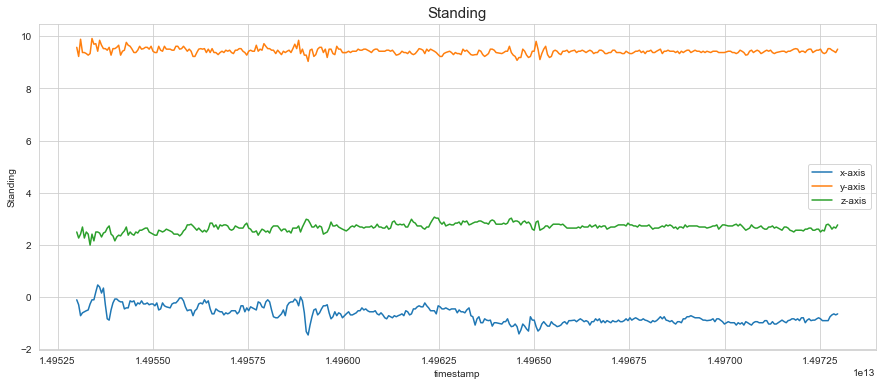

In [11]:
# For a particular user, lets observe how the signal values in each of the x, y and z dimension varies with time.
for i in ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']:
  data_36 = df[(df['user'] == 36) & (df['activity'] == i)][:400]
  plt.figure(figsize = (15, 6))
  sns.lineplot(y = 'x-axis', x = 'timestamp', data = data_36)
  sns.lineplot(y = 'y-axis', x = 'timestamp', data = data_36)
  sns.lineplot(y = 'z-axis', x = 'timestamp', data = data_36)
  plt.legend(['x-axis', 'y-axis', 'z-axis'])
  plt.ylabel(i)
  plt.title(i, fontsize = 15)
  plt.show()

 We have considered a subset of 400 samples for visualising the signal. This is equivalent to 20 secs of the activity (as the frequency of data collection was 20 Hz). As you can notice, the signals shows periodic behaviour for the activities like Walking, Jogging, Upstairs and Downstairs while it has very less movement for stagnant activities like Sitting and Standing.

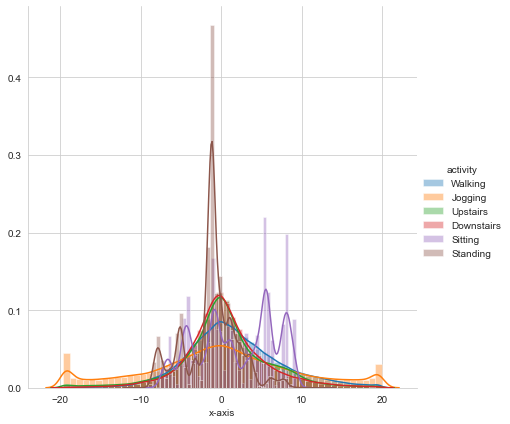

In [12]:
# Now let’s observe activity-wise distribution of the signal data along x, y and z axes to 
# see if there is any obvious pattern based on the range and distribution of the values.

sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'x-axis').add_legend()

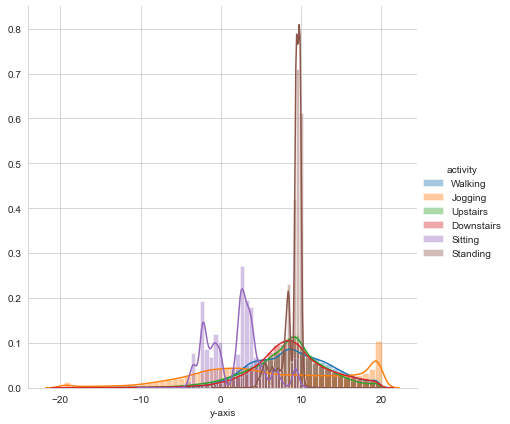

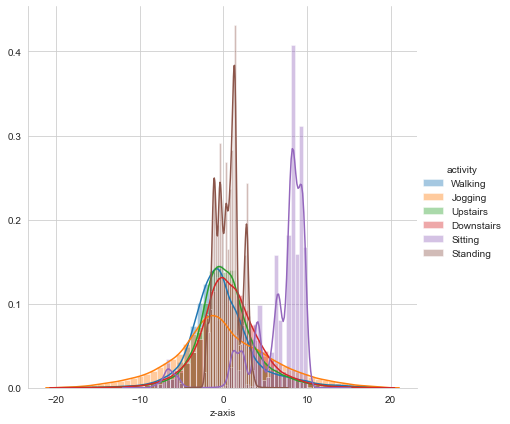

In [13]:
# sns.FacetGrid(df, size = 6).map(sns.distplot, 'x-axis').add_legend()

sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'y-axis').add_legend()

sns.FacetGrid(df, hue = 'activity', size = 6).map(sns.distplot, 'z-axis').add_legend()

It is observed that there is very high overlap in the data among activities like Upstairs, Downstairs, Walking, Jogging and Standing on all the axes. Sitting somewhat appears to have  distinctive values along y-axis and z-axis.

This bring us to the heart of the article, that is Data transformation and Feature engineering.

# Data Transformation

 Standard classification algorithms cannot be directly applied to the raw time-series data. 
Instead, we must first transform the raw time-series data using ‘windowing’ technique. In this 
technique, we divide the data into windows of 5 seconds, and then we generate new features by 
aggregating the 100 raw samples contained within each of these 5 second segments. For assigning 
class-label against the transformed features, we take the most frequent activity in that window.

For example, let’s say a raw dataset has 100 rows of sequential data. So after windowing and 
aggregation (using window size = 50), it will be transformed into 2 rows. The class-label 
assigned for these 2 new rows will be the most frequent activity in the respective window. 
Likewise, for 1 million rows, we will be getting nearly a total of 20k rows in transformed set.

There is one more thing we can do here— instead of taking discrete windows, we take overlapping 
windows with 50% overlap. This ensures that every subsequent row in the transformed dataset has 
some information from the data in previous window as well.

# Feature Engineering

In [14]:
# Before we start designing new features, we must first split the data into train and test. 
# Typically we tend to do random splitting, but here in this specific scenario, splitting as 
# per the User ID makes more sense.

# So out of total 36 users, the data of first 27 users will form our train data while rest 9 
# users will be included in our test data.

# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df['user'] <= 27]

# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df['user'] > 27]

# Feature Engineering Stage 1: Statistical measures

In [15]:
# In the stage 1 of the feature engineering, we will build a total of 18 simple statistical features —
# 1. mean
# 2. standard deviation
# 3. average absolute deviation
# 4. minimum value
# 5. maximum value
# 6. difference of maximum and minimum values
# 7. median
# 8. median absolute deviation
# 9. interquartile range
# 10. negative values count
# 11. positive values count
# 12. number of values above mean
# 13. number of peaks
# 14. skewness
# 15. kurtosis
# 16. energy
# 17. average resultant acceleration
# 18. signal magnitude area

#     Energy of a signal in every axis is computed by taking the mean of sum of squares of the values 
#         in a window in that particular axis.
#     Average resultant acceleration over the window is computed by taking average of the square roots 
#         of the values in each of the three axis squared and added together.
#     Signal magnitude area is defined as the sum of absolute values of the three axis averaged over a window.


In [16]:
x_list = []
y_list = []
z_list = []
train_labels = []

window_size = 100
step_size = 50

In [17]:
# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x-axis'].values[i: i + 100]
    ys = df_train['y-axis'].values[i: i + 100]
    zs = df_train['z-axis'].values[i: i + 100]
    label = stats.mode(df_train['activity'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [18]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

In [19]:
# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

In [20]:
# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

In [21]:
# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

In [22]:
# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

In [23]:
# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

In [24]:
# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

In [25]:
# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

In [26]:
# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

In [27]:
# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

In [28]:
# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

In [29]:
# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

In [30]:
# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

In [31]:
# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

In [32]:
# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

In [33]:
# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

In [34]:
# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

In [35]:
# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

In [36]:
# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

# Feature Engineering Stage 2: Fast-Fourier transform (FFT)

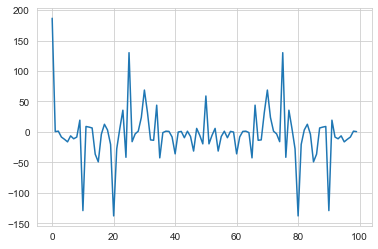

In [37]:
# So far we have been dealing in the time domain. Let’s take any random window from our data and 
# observe discrete Fourier transform of it —

pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.show()

In [38]:
# Don’t bother much about the DC component, think of it as an unusually high value that we are 
# going to discard. Also we are going to consider only first half of the signal. This will ensure 
# that we obtain unbiased statistical features from it.
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

In [39]:
# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

In [40]:
# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

In [41]:
# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

In [42]:
# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

In [43]:
# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

In [44]:
# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

In [45]:
# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

In [46]:
# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

In [47]:
# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

In [48]:
# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

In [49]:
# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

In [50]:
# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

In [51]:
# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

In [52]:
# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

In [53]:
# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

In [54]:
# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))

# Feature Engineering Stage 3: Capturing indices

In [55]:
# The main goal of the feature engineering stage in any machine learning problem is 
# to provide as much possible information to the model. More information you provide, better it learns!

# So here in this case, why not take a look at index values of the underlying data as potential features?


In [56]:
# Max Indices and Min indices 

# index of max value in time domain
X_train['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
X_train['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
X_train['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

In [57]:
# index of min value in time domain
X_train['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
X_train['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
X_train['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))


In [58]:
# absolute difference between above indices
X_train['x_arg_diff'] = abs(X_train['x_argmax'] - X_train['x_argmin'])
X_train['y_arg_diff'] = abs(X_train['y_argmax'] - X_train['y_argmin'])
X_train['z_arg_diff'] = abs(X_train['z_argmax'] - X_train['z_argmin'])

In [59]:
# index of max value in frequency domain
X_train['x_argmax_fft'] = pd.Series(x_list).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_train['y_argmax_fft'] = pd.Series(y_list).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_train['z_argmax_fft'] = pd.Series(z_list).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

In [60]:
# index of min value in frequency domain
X_train['x_argmin_fft'] = pd.Series(x_list).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_train['y_argmin_fft'] = pd.Series(y_list).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_train['z_argmin_fft'] = pd.Series(z_list).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

In [61]:
# absolute difference between above indices
X_train['x_arg_diff_fft'] = abs(X_train['x_argmax_fft'] - X_train['x_argmin_fft'])
X_train['y_arg_diff_fft'] = abs(X_train['y_argmax_fft'] - X_train['y_argmin_fft'])
X_train['z_arg_diff_fft'] = abs(X_train['z_argmax_fft'] - X_train['z_argmin_fft'])

In [62]:
# Likewise, follow the same steps as above for transforming raw test dataframe df_test and extracting 
# features from it to build the transformed test dataset i.e. X_test. The new X_test dataset will have int(281002/50)-1 = 5619 rows 

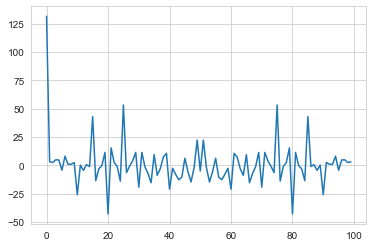

In [63]:
x_list = []
y_list = []
z_list = []
test_labels = []

window_size = 100
step_size = 50

# creating overlaping windows of size window-size 100
for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x-axis'].values[i: i + 100]
    ys = df_test['y-axis'].values[i: i + 100]
    zs = df_test['z-axis'].values[i: i + 100]
    label = stats.mode(df_test['activity'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))


# =============================================================================
# Feature Engineering Stage 2: Fast-Fourier transform (FFT)
# =============================================================================


# So far we have been dealing in the time domain. Let’s take any random window from our data and 
# observe discrete Fourier transform of it —

pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.show()

# Don’t bother much about the DC component, think of it as an unusually high value that we are 
# going to discard. Also we are going to consider only first half of the signal. This will ensure 
# that we obtain unbiased statistical features from it.

# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))


# =============================================================================
# Feature Engineering Stage 3: Capturing indices
# =============================================================================

# The main goal of the feature engineering stage in any machine learning problem is 
# to provide as much possible information to the model. More information you provide, better it learns!

# So here in this case, why not take a look at index values of the underlying data as potential features?


# Max Indices and Min indices 

# index of max value in time domain
X_test['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
X_test['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
X_test['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

# index of min value in time domain
X_test['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
X_test['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
X_test['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

# absolute difference between above indices
X_test['x_arg_diff'] = abs(X_test['x_argmax'] - X_test['x_argmin'])
X_test['y_arg_diff'] = abs(X_test['y_argmax'] - X_test['y_argmin'])
X_test['z_arg_diff'] = abs(X_test['z_argmax'] - X_test['z_argmin'])

# index of max value in frequency domain
X_test['x_argmax_fft'] = pd.Series(x_list).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_test['y_argmax_fft'] = pd.Series(y_list).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
X_test['z_argmax_fft'] = pd.Series(z_list).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

# index of min value in frequency domain
X_test['x_argmin_fft'] = pd.Series(x_list).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_test['y_argmin_fft'] = pd.Series(y_list).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
X_test['z_argmin_fft'] = pd.Series(z_list).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

# absolute difference between above indices
X_test['x_arg_diff_fft'] = abs(X_test['x_argmax_fft'] - X_test['x_argmin_fft'])
X_test['y_arg_diff_fft'] = abs(X_test['y_argmax_fft'] - X_test['y_argmin_fft'])
X_test['z_arg_diff_fft'] = abs(X_test['z_argmax_fft'] - X_test['z_argmin_fft'])


# Implementing a Linear model for Activity Prediction

In [71]:
# The idea is, logistic regression being a linear classifier, it heavily relies upon 
# the quality of the features in order to give good results. More distinctive information 
# the features provide, better is the performance. Thus, if we are able to obtain better 
# performance using logistic regression, then we can say that we have been successful in 
# creating the right set of features.

In [64]:
# =============================================================================
# Logistic Regression model
# =============================================================================
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [65]:
# For logistic regression, it is recommended to first standardize the data.

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [66]:
# standardization
scaler = StandardScaler()

In [67]:
#fit(X[, y, sample_weight])
#Compute the mean and std to be used for later scaling.
scaler.fit(X_train)

StandardScaler()

In [68]:
# transform(X[, copy])
# Perform standardization by centering and scaling
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)

In [69]:
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8483715963694608

 -------------Classification Report-------------

              precision    recall  f1-score   support

  Downstairs       0.70      0.75      0.73       576
     Jogging       0.82      0.95      0.88      1522
     Sitting       0.87      1.00      0.93       361
    Standing       0.96      0.82      0.88       323
    Upstairs       0.71      0.67      0.69       640
     Walking       0.95      0.84      0.89      2197

    accuracy                           0.85      5619
   macro avg       0.83      0.84      0.83      5619
weighted avg       0.85      0.85      0.85      5619



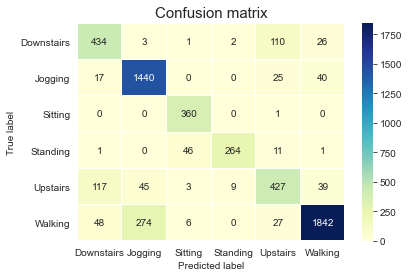

In [71]:
# Let’s check the Confusion matrix.
from sklearn.metrics import confusion_matrix

labels = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']
confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, xticklabels=labels, yticklabels=labels, annot=True,linewidths = 0.1, fmt="d", cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

From the Classification report and Confusion matrix, it can be observed that Jogging and Walking, the two most common classes in our dataset are correctly identified with good accuracy. Although there are very few samples of Sitting and Standing classes, we can still identify these activities quite well, because the two activities cause the device to change orientation and this is easily detected from the accelerometer data. To more accurately differentiate between Upstairs and Downstairs activties, the existing set of features are not enough. By coupling the tri-axial accelerometer data with the data from tri-axial gyroscope (another inertial sensor in smart devices), it can be possible to distinguish between these classes as well as recognize other activities with greater accuracy.
